## ASTR496: Foundations of Data Science in Astronomy
Gautham Narayan
gsn@illinois.edu

### Midterm

In [120]:
# Q1: Maximum Likelihood Estimation for Stellar Parameters
# Estimating Temperature and Extinction from Multi-band Photometry

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

#### **Problem Setup:**
#### - We observe a star in multiple photometric bands (B, V, R, I, J, H, K)
#### - We want to estimate: stellar temperature T and visual extinction A_V
#### - We assume we know the distance from e.g. Gaia (or fit for it separately)
####
#### **Model:**
#### For each filter λ, the observed magnitude is:
####
#### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ
####
#### where:
#### - M_λ(T) = absolute magnitude in filter λ for temperature T
#### - d = distance in parsecs
#### - A_V = visual extinction
#### - R_λ = extinction coefficient for filter λ

### First, I have to give you a stellar model as a function of wavelength
### We'll use a Planck function i.e. a blackbody

In [121]:
def planck_function(wavelength, temperature):
    """
    Planck function for blackbody radiation
    wavelength in microns, temperature in Kelvin
    Returns relative flux (arbitrary units)
    """
    h = 6.626e-34  # Planck constant
    c = 3e8        # Speed of light
    k = 1.381e-23  # Boltzmann constant

    wl_m = wavelength * 1e-6  # Convert to meters

    # Planck function
    numerator = 2 * h * c**2
    denominator = wl_m**5 * (np.exp(h * c / (wl_m * k * temperature)) - 1)

    return numerator / denominator

### Next we need to define a photometric system - we'll use the Johnson(-Morgan) Kron-Cousins UBVRI filters and the reddening coefficients 
### and JHK for the IR, largely because you can look up the filter's effective wavelengths $\lambda_\text{eff}$ in microns and the reddening coefficients from something like Cardelli-Clayton-Mathis '89.

In [122]:
filters = {
    'B': {'lambda_eff': 0.44, 'R_lambda': 4.1},   # Blue
    'V': {'lambda_eff': 0.55, 'R_lambda': 3.1},   # Visual (reference)
    'R': {'lambda_eff': 0.64, 'R_lambda': 2.7},   # Red
    'I': {'lambda_eff': 0.79, 'R_lambda': 2.0},   # Near-IR
    'J': {'lambda_eff': 1.25, 'R_lambda': 0.9},   # IR
    'H': {'lambda_eff': 1.63, 'R_lambda': 0.6},   # IR
    'K': {'lambda_eff': 2.19, 'R_lambda': 0.4}    # IR
}

In [123]:
# here are some quick arrays of the filters, wavelengths and reddening coefficients.
filter_names = list(filters.keys())
wavelengths = np.array([filters[f]['lambda_eff'] for f in filter_names])
R_lambda = np.array([filters[f]['R_lambda'] for f in filter_names])

print(f"Photometric filters: {filter_names}")
print(f"Effective wavelengths (μm): {wavelengths}")
print(f"Extinction coefficients R_λ: {R_lambda}")

Photometric filters: ['B', 'V', 'R', 'I', 'J', 'H', 'K']
Effective wavelengths (μm): [0.44 0.55 0.64 0.79 1.25 1.63 2.19]
Extinction coefficients R_λ: [4.1 3.1 2.7 2.  0.9 0.6 0.4]


### Next, we need to reate the magnitudes of a star, given the spectral model 
### While we are using the Planck function as an approximation, we'll tie the fluxes to the obsserved flux of the 
### Sun itself, with $T_\text{eff}= 5778$K, and $M_V = 4.83$ (remember the absolute magnitude is defined for a distance of 10pc).

In [124]:
# Create stellar atmosphere model
def stellar_magnitude(temperature, filter_name, reference_temp=5778):
    """
    Calculate absolute magnitude for a star of given temperature
    Simplified model based on Planck function + calibration
    """
    wl = filters[filter_name]['lambda_eff']

    # Get flux ratio compared to solar temperature
    flux_star = planck_function(wl, temperature)
    flux_sun = planck_function(wl, reference_temp)
    flux_ratio = flux_star / flux_sun

    # Convert to magnitude difference (Sun has M_V = 4.83)
    # Add wavelength-dependent correction for more realism
    solar_magnitude = 4.83 + 0.5 * (wl - 0.55)  # Rough color correction

    magnitude = solar_magnitude - 2.5 * np.log10(flux_ratio)

    return magnitude

### Q1. As a function of temperature (3000-10,000K in 1000K steps) determine the B-V color

In [125]:
### YOUR ANSWER HERE
temp = np.arange(3000, 11000, 1000)
for t in temp:
    B_mag = stellar_magnitude(t, 'B')
    V_mag = stellar_magnitude(t, 'V')
    BV_color = B_mag - V_mag
    print(f"B: {B_mag}, V: {V_mag}, B-V: {BV_color}")

B: 10.471012965822585, V: 9.39540060151893, B-V: 1.0756123643036553
B: 7.510880175876717, V: 7.0261336400632945, B-V: 0.4847465358134224
B: 5.733710909623768, V: 5.6011679417724825, B-V: 0.13254296785128528
B: 4.546672754484878, V: 4.6458823224450105, B-V: -0.09920956796013236
B: 3.695476672356698, V: 3.957146983564318, B-V: -0.26167031120761974
B: 3.0530696145610197, V: 3.4338693939513667, B-V: -0.38079977939034704
B: 2.5490692425404027, V: 3.0202827403724717, B-V: -0.471213497832069
B: 2.1414466635118394, V: 2.683198333720404, B-V: -0.5417516702085647


### Next, I'll give you the "Truth" and some synthetic stellar data, with the true magnitudes of this star in each band using my `stellar_magnitude` but with the reddening and distance correction applied (you're going to have to do this)

In [126]:
# Generate a test star
TRUE_TEMP = 6500  # K
TRUE_A_V = 0.8    # magnitudes
TRUE_DISTANCE = 100    # parsecs


synthetic_star =  {'B': {'magnitude': 12.379, 'error': 0.02, 'true_magnitude': 12.369},
                   'V': {'magnitude': 11.752, 'error': 0.03, 'true_magnitude': 11.756},
                   'R': {'magnitude': 11.579, 'error': 0.04, 'true_magnitude': 11.553},
                   'I': {'magnitude': 11.225, 'error': 0.05, 'true_magnitude': 11.149},
                   'J': {'magnitude': 10.602, 'error': 0.06, 'true_magnitude': 10.616},
                   'H': {'magnitude': 10.592, 'error': 0.07, 'true_magnitude': 10.609},
                   'K': {'magnitude': 10.888, 'error': 0.08, 'true_magnitude': 10.762}}

### Q2.  
### OK, you know the drill 
### define a function that gives you the model magnitudes of the star given the temperature, extinction and distance
### define the log-likelihood
### Use `scipy.optimize` to get the best fit parameters for this star using maximum likelihood estimation
### Calculate the goodness of fit i.e. reduced chi-squared
### Calculate the Inverse Hessian Matrix and report the simple uncertainties on each parameter
### Which parameters are correlated strongly?

In [127]:
# Initial guess
initial_guess = [5500, 0.5, 75]  # Temperature, A_V, Distance

### YOUR ANSWER HERE
def model_mag(temperature, A_V, d, filter_names):
    mags = np.array([stellar_magnitude(temperature, f) for f in filter_names])
    R_lambda = np.array([filters[f]['R_lambda'] for f in filter_names]) 
    m_lambda = mags + 5*np.log10(d / 10) + A_V * R_lambda
    return m_lambda

In [128]:
def neg_log_likelihood(theta, filter_names, obs_mag, mag_err): 
    temperature, A_V, d = theta
    residuals = ((obs_mag - model_mag(temperature, A_V, d, filter_names)) / mag_err) 
    return 0.5 * np.sum(residuals**2)

In [129]:
from scipy.optimize import minimize

obs_mag = np.array([synthetic_star[f]['magnitude'] for f in filter_names])
mag_err = np.array([synthetic_star[f]['error'] for f in filter_names])
best_fit = minimize(neg_log_likelihood, initial_guess, args = (filter_names, obs_mag, mag_err))
T_fit, A_V_fit, d_fit = best_fit.x
print(f"Best T: {T_fit}, Best A_V: {A_V_fit}, Best distance: {d_fit}")

Best T: 7638.856525905675, Best A_V: 0.9422230692740027, Best distance: 111.83031116141433


In [130]:
chi2 = np.sum(((obs_mag - model_mag(T_fit, A_V_fit, d_fit, filter_names)) / mag_err)**2)
N = len(obs_mag)
k = 3
red_chi2 = chi2 / (N - k)
red_chi2

np.float64(0.8271835224854477)

In [131]:
H = np.array(best_fit.hess_inv)
errors = np.sqrt(np.diag(H))
print("Covariance matrix:\n", H)

print(f"temperature = {best_fit.x[0]} +- {errors[0]}")
print(f"A_V = {best_fit.x[1]} +- {errors[1]}")
print(f"d = {best_fit.x[2]} +- {errors[2]}")

Covariance matrix:
 [[6.99996826e+04 9.00382198e+00 3.47759906e+02]
 [9.00382198e+00 1.29981794e-03 2.15047871e-02]
 [3.47759906e+02 2.15047871e-02 6.19300063e+00]]
temperature = 7638.856525905675 +- 264.5745313601347
A_V = 0.9422230692740027 +- 0.03605298797833421
d = 111.83031116141433 +- 2.4885740158511105


In [132]:
corr = H / np.outer(errors, errors)
print(corr)

[[1.         0.94392524 0.52817874]
 [0.94392524 1.         0.23968636]
 [0.52817874 0.23968636 1.        ]]


all of them are correlated apparantly. 0.94 (strong) between AV and temp, 0.52 (moderate) between d and temp, 0.23 (weak) between AV and d

### Q3.

### It is worth remembering the difference between Monte Carlo and Markov Chain Monte Carlo
### Using the same true parameters provided to you with Q2, generate 1000 random stars with the same true values, but different random seeds
### Repeat your analysis in Q2 for each of these 1000 stars, saving the results
### Use the results from this Monte Carlo process to determine a more robust uncertainty estimate, and measure the mean bias (i.e. how far are you from the truth) in parameter recovery

difference b/w monte carlo and markov chain monte carlo.     
monte carlo: uses random sampling to estimate uncertainty. the samples are independent of each other. Its like using random nums to explore noise, variability. no memory b/w draws.         
markov chain monte carlo: the samples are correlated. forms a chain where each sample is dependent on the previous one. as chain memory.  

there was a lot to unpack here. here is my understanding of it.
I generate 1000 stars with our true params then we add some random noise in each of them which technically creates 1000 different stars.     
Then we run MLE using minimize over that and extract the best fit params.          
Then we subtract those best fits with true params to see our bias.    
mean of that -> mean bias 

In [133]:
### YOUR ANSWER HERE
N = 1000
true_params = [TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE] 
true_mags = model_mag(TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE, filter_names)
results = np.empty((N, 3))

for i in range(1000):
    rng = np.random.default_rng(i) # didnt know how to seed properly so gpt suggested this function.
    noise = rng.normal(0, mag_err) #add some centered gaussian noise with the same errors 
    obs_mag = true_mags + noise
    res = minimize(neg_log_likelihood, initial_guess, args = (filter_names, obs_mag, mag_err))
    results[i] = res.x

delta = results - true_params
mean_bias = delta.mean(axis = 0) # applying over each first row res[temp, av, d] - true_params[trueT, true AV, true d]
SD = delta.std(axis = 0)
print(f"Mean bias: {mean_bias} \n SD: {SD})")

Mean bias: [3.12396067e+02 3.12421091e-03 1.98356796e+00] 
 SD: [1.45699612e+03 1.98457074e-01 1.23896483e+01])


### Q4. 

### Finally, try this problem with a Markov Chain Monte Carlo but this time, incorporating a prior on the distance of 98 +/- 5 pc from synthetic Gaia, but repeating the anaysis three times - once with all filters, next with RIJHK and then with BVRIJ only.

#### Make reasonable choices for the number of walkers, steps, thinning etc. It's your responsibility to ensure the posteriors are well sampled.

### Show corner plots for all three cases in the same figure (you can try the `ChainConsumer` package)

### How do these results compare, and what happens to the extinction and temperature with fewer bands, and in the case of all filters, with your answer from Q2/Q3. 


For All Filters filters:
Mean bias: [2.15247710e+03 2.06318522e-01 1.93548707e+01]
SD: [1.66601288e+03 1.59860347e-01 1.34098360e+01]

For RIJHK filters:
Mean bias: [2.74110356e+03 2.15952242e-01 2.59530305e+01]
SD: [1.98185155e+03 1.88085080e-01 1.81812258e+01]


Parameter Temperature (K) in chain All Filters is not constrained
Parameter Temperature (K) in chain RIJHK is not constrained



For BVRIJ filters:
Mean bias: [2.22980481e+03 2.22532799e-01 1.86475873e+01]
SD: [1.62772127e+03 1.49894302e-01 1.24870766e+01]


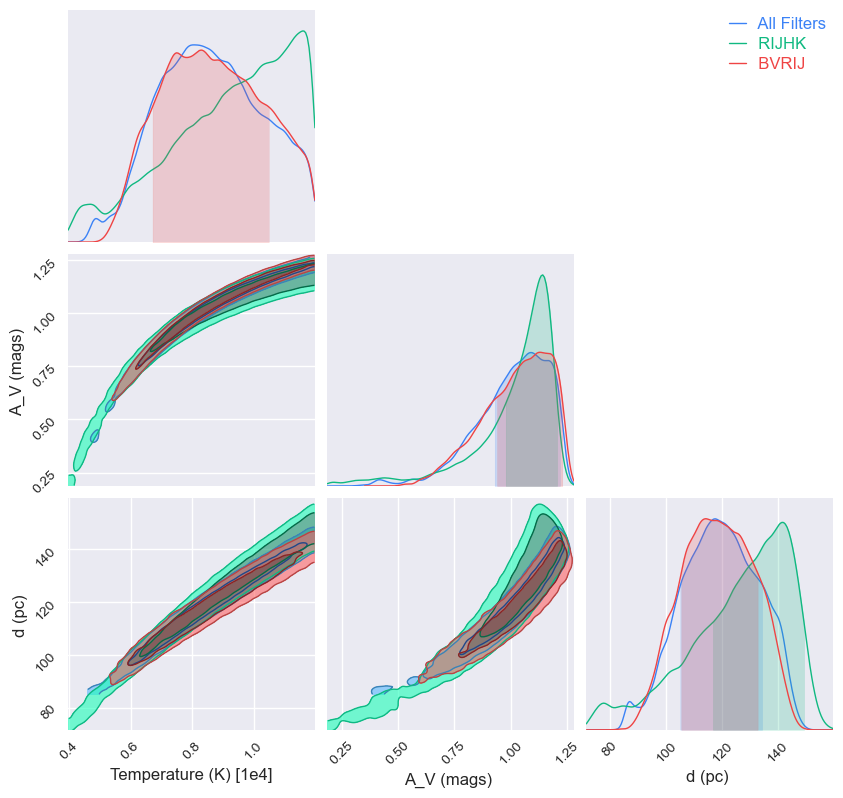

In [161]:
### YOUR ANSWER HERE
from chainconsumer import Chain, ChainConsumer
import emcee

def log_prior(theta):
    temperature = theta[0]
    A_V = theta[1]
    d = theta[2]
    #true temp is 6.5k so half of that seems decent and double of that should also be a decent bound.
    #true AV is 0.8 so absolute worst case 4 
    #true d is 100 so 5x that should be fine as a found. (i thought 500 is too much but Deneb is 460 away)
    if (temperature < 3000 or temperature > 12000) or\
        (A_V <= 0 or A_V > 4)  or\
        (d < 0.1 or  d > 500):   
        return -np.inf
    return 0.0

def log_posterior(theta, filter_names, obs_mag, mag_err):
    lp = log_prior(theta)
    if not np.isfinite(lp): 
        return -np.inf
    return lp - neg_log_likelihood(theta, filter_names, obs_mag, mag_err)



bands = [
    {"label": "All Filters", "filters": ["B","V","R","I","J","H","K"]},
    {"label": "RIJHK",       "filters": ["R","I","J","H","K"]},
    {"label": "BVRIJ",       "filters": ["B","V","R","I","J"]},
]

params = ["Temperature (K)", "A_V (mags)", "d (pc)"]

consumer = ChainConsumer()

for band in bands:
    filt = band['filters']
    label = band['label']

    obs_mag = np.array([synthetic_star[f]['magnitude'] for f in filt])
    mag_err = np.array([synthetic_star[f]['error'] for f in filt])

    ndim = 3 #our num of params
    nwalkers = 20 # always! > num_params x 2 
    nsteps = 20000

    guess = np.array([TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE], dtype=float)
    scatter = np.array([80.0, 0.02, 1.0]) * np.random.randn(nwalkers, ndim)
    scattered_guess = guess + scatter

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(filt ,obs_mag, mag_err))
    burn = 1000
    sampler.run_mcmc(scattered_guess, burn)
    sampler.reset()
    sampler.run_mcmc(None, nsteps)
    samples = sampler.get_chain(discard=1000, thin=10, flat=True)

    df = pd.DataFrame(samples, columns=params)  
    chain = Chain(samples=df, name=label)  
    consumer.add_chain(chain)

    median = np.median(samples, axis=0)
    SD = np.std(samples, axis=0)

    delta = samples - true_params
    mean_bias = delta.mean(axis=0)
    std = delta.std(axis=0, ddof=1)

    print(f"\nFor {band['label']} filters:")
    print(f"Mean bias: {mean_bias}")
    print(f"SD: {std}")

fig = consumer.plotter.plot()

I know they dont look great but I gave this question a good 2 days and this is all i could get to in the end. the BVRIJ complete dominate over the RIJHK and that also makes sense because some of our true params lie inside BVRIJ like temp. MCMC is clearly the best choice out of all our options.